In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

from load_wastewater_data import load_systems_data

# Update rcParams to set the default font to Times New Roman
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'DejaVu Serif'

In [44]:
plot_path = f"../plots/wastewater_model/normalization_strategies/PMMoV"
data_output_path = f"../data/PMMoV_normalization"
os.makedirs(os.path.join(plot_path), exist_ok=True)
os.makedirs(os.path.join(data_output_path), exist_ok=True)
# file_name_prefix = f"{substance}_{rain_scenario}_{degradation_setting}"

In [45]:
# define experiment to be preprocessed
experiment_series = "2024_09_17"

resolution = "3_min_resolution" 
rain_scenario = "Nieselregen" # one of Nieselregen, MittelstarkerRegen
degradation_setting = "no_decay"

In [46]:
# Load Data
df_KeinRegen = load_systems_data(experiment_series, resolution, "KeinRegen", degradation_setting, file_type="concentrations") 
df_Rain = load_systems_data(experiment_series, resolution, rain_scenario, degradation_setting, file_type="concentrations")

In [47]:
df_KeinRegen.shape

(26880000, 6)

In [48]:
df_Rain.shape

(26880000, 6)

### Normalisation with PMMoV

copies/l normalized = (copies/l of RNA) * (mean value of the normalization parameter on dry days) / (value of the normalization parameter)

source: https://pubs.acs.org/doi/10.1021/acsestwater.2c00306


#### Apply normalization of PMMoV values

In [49]:
# normalize w.r.t. PMMoV values
mean_values = df_KeinRegen.groupby(["sampling_point", "memilio_id"])["PMMoV_copies/l"].mean().reset_index().rename(columns={"PMMoV_copies/l": "PMMoV_mean_copies/l"})
df_Rain = pd.merge(df_Rain, mean_values, on=["sampling_point", "memilio_id"], how="left")

normalization_factors = df_Rain.loc[:,["time_in_days", "sampling_point", "memilio_id"]].copy()
normalization_factors["PMMoV_normalization_factor"] = df_Rain["PMMoV_mean_copies/l"]/df_Rain["PMMoV_copies/l"]

df_Rain = pd.merge(df_Rain.loc[:,["time_in_days", "sampling_point", "memilio_id", "COVID_copies/l", "PMMoV_copies/l"]], normalization_factors, on=["sampling_point", "memilio_id", "time_in_days"], how="inner")
df_Rain["PMMoV_normalized_copies/l"] = df_Rain["COVID_copies/l"]*df_Rain["PMMoV_normalization_factor"]
df_Rain.sort_values("time_in_days", inplace=True)

#### Store normalized data and calculate metrics

In [50]:
df_Rain.to_csv(os.path.join(data_output_path, f"normalized_{degradation_setting}_{rain_scenario}.csv"), index=False)

Metrics:

absolute error
$|{y_{no-rain}-y_{rain-normalized}}|$

relative error 
$\frac{|{y_{no-rain}-y_{rain-normalized}}|}{y_{no-rain}}$

averaged over all timepoints t

calculated individually per sampling location, simulation id

In [51]:
df_KeinRegen2 = df_KeinRegen[["time_in_days", "sampling_point", "memilio_id", "COVID_copies/l"]].copy()
df_KeinRegen2.columns = ["time_in_days", "sampling_point", "memilio_id", "KeinRegen_copies/l"]

df_combined = df_Rain.merge(df_KeinRegen2, on=["time_in_days", "sampling_point", "memilio_id"], how="outer")

In [52]:
# calculate metrics
df_combined["absolute_error_unnormalized"] = np.abs(df_combined["COVID_copies/l"] - df_combined["KeinRegen_copies/l"])
df_combined["absolute_error"] = np.abs(df_combined["PMMoV_normalized_copies/l"] - df_combined["KeinRegen_copies/l"])
df_combined["relative_error_unnormalized"] = df_combined["absolute_error_unnormalized"]/df_combined["KeinRegen_copies/l"]
df_combined["relative_error"] = df_combined["absolute_error"]/df_combined["KeinRegen_copies/l"]

In [53]:
df_metrics = df_combined.groupby(["sampling_point", "memilio_id"]).agg({"absolute_error": "mean", "relative_error": "mean",
                                                                        "absolute_error_unnormalized": "mean", "relative_error_unnormalized": "mean"})

df_metrics["NaNs_KeinRegen"] = df_KeinRegen2.groupby(["sampling_point", "memilio_id"]).apply(lambda x: x["KeinRegen_copies/l"].isna().sum())
df_metrics["NaNs_Regen"] = df_Rain.groupby(["sampling_point", "memilio_id"]).apply(lambda x: x["COVID_copies/l"].isna().sum())

df_metrics.reset_index(inplace=True)
df_metrics.to_csv(os.path.join(data_output_path, f"metrics_{degradation_setting}_{rain_scenario}.csv"), index=False)

/tmp/ipykernel_134208/85663379.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_metrics["NaNs_KeinRegen"] = df_KeinRegen2.groupby(["sampling_point", "memilio_id"]).apply(lambda x: x["KeinRegen_copies/l"].isna().sum())
/tmp/ipykernel_134208/85663379.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_metrics["NaNs_Regen"] = df_Rain.groupby(["sampling_point", "memilio_id"]).apply(lambda x: x["COVID_c

In [54]:
metrics_per_sampling_point = df_metrics.groupby("sampling_point").mean().reset_index()[['sampling_point', 'absolute_error', 'relative_error',
       'absolute_error_unnormalized', 'relative_error_unnormalized', 'NaNs_KeinRegen', 'NaNs_Regen']]
metrics_per_sampling_point

,sampling_point,absolute_error,relative_error,absolute_error_unnormalized,relative_error_unnormalized,NaNs_KeinRegen,NaNs_Regen
0,1,1.275585,inf,5.781779,inf,0.0,0.0
1,10,1.229475,inf,6.628439,inf,0.0,0.0
2,11,8.041733,inf,8.415749,inf,0.0,0.0
3,12,1.736493,inf,8.963410,inf,0.0,0.0
4,13,1.466887,inf,8.051414,inf,0.0,0.0
5,14,1.567236,inf,9.163337,inf,0.0,0.0
6,15,1.873841,inf,8.614683,inf,0.0,0.0
7,16,1.387612,inf,9.090979,inf,0.0,0.0
8,2,1.248782,inf,6.344081,inf,0.0,0.0
9,3,1.225685,inf,6.242928,inf,0.0,0.0


#### Subselect specific sampling location

In [55]:
#subselect specific sampling point
sampling_point = "16"

df_KeinRegen = df_KeinRegen.loc[df_KeinRegen.sampling_point==sampling_point, :].copy()
df_Rain = df_Rain.loc[df_Rain.sampling_point==sampling_point, :].copy()

In [56]:
df_Rain.head()

,time_in_days,sampling_point,memilio_id,COVID_copies/l,PMMoV_copies/l,PMMoV_normalization_factor,PMMoV_normalized_copies/l
24834525,0.002083,16,224,0.0,0.0,inf,NaN
11871645,0.002083,16,71,0.0,0.0,inf,NaN
22536285,0.002083,16,47,0.0,0.0,inf,NaN
20291805,0.002083,16,218,0.0,0.0,inf,NaN
393885,0.002083,16,199,0.0,0.0,inf,NaN


#### Basic Visualization of PMMoV Data

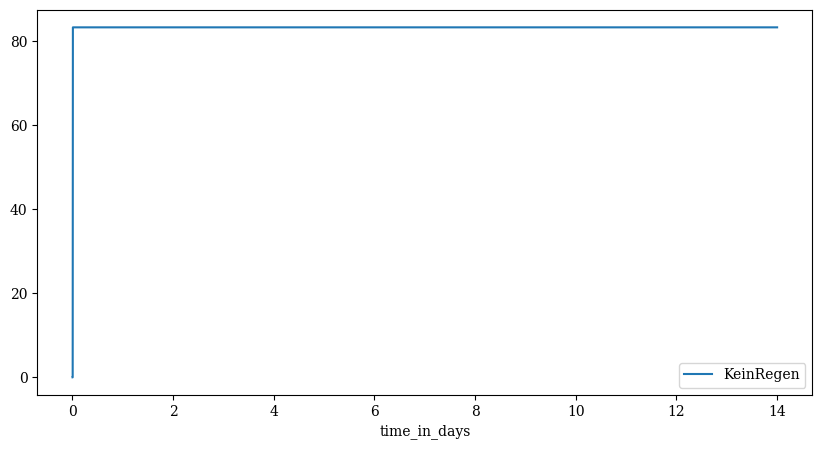

In [40]:
df_KeinRegen.sort_values("time_in_days", inplace=True)
df_KeinRegen.plot(x="time_in_days", y="PMMoV_copies/l", label="KeinRegen", figsize=(10, 5))
plt.show()

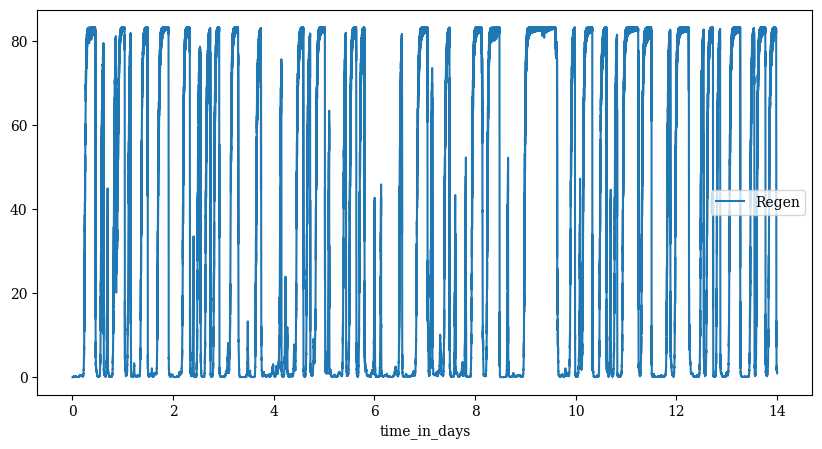

In [41]:
df_Rain.sort_values("time_in_days", inplace=True)
df_Rain.plot(x="time_in_days", y="PMMoV_copies/l", label="Regen", figsize=(10, 5))
plt.show()

#### Visualization of Normalization

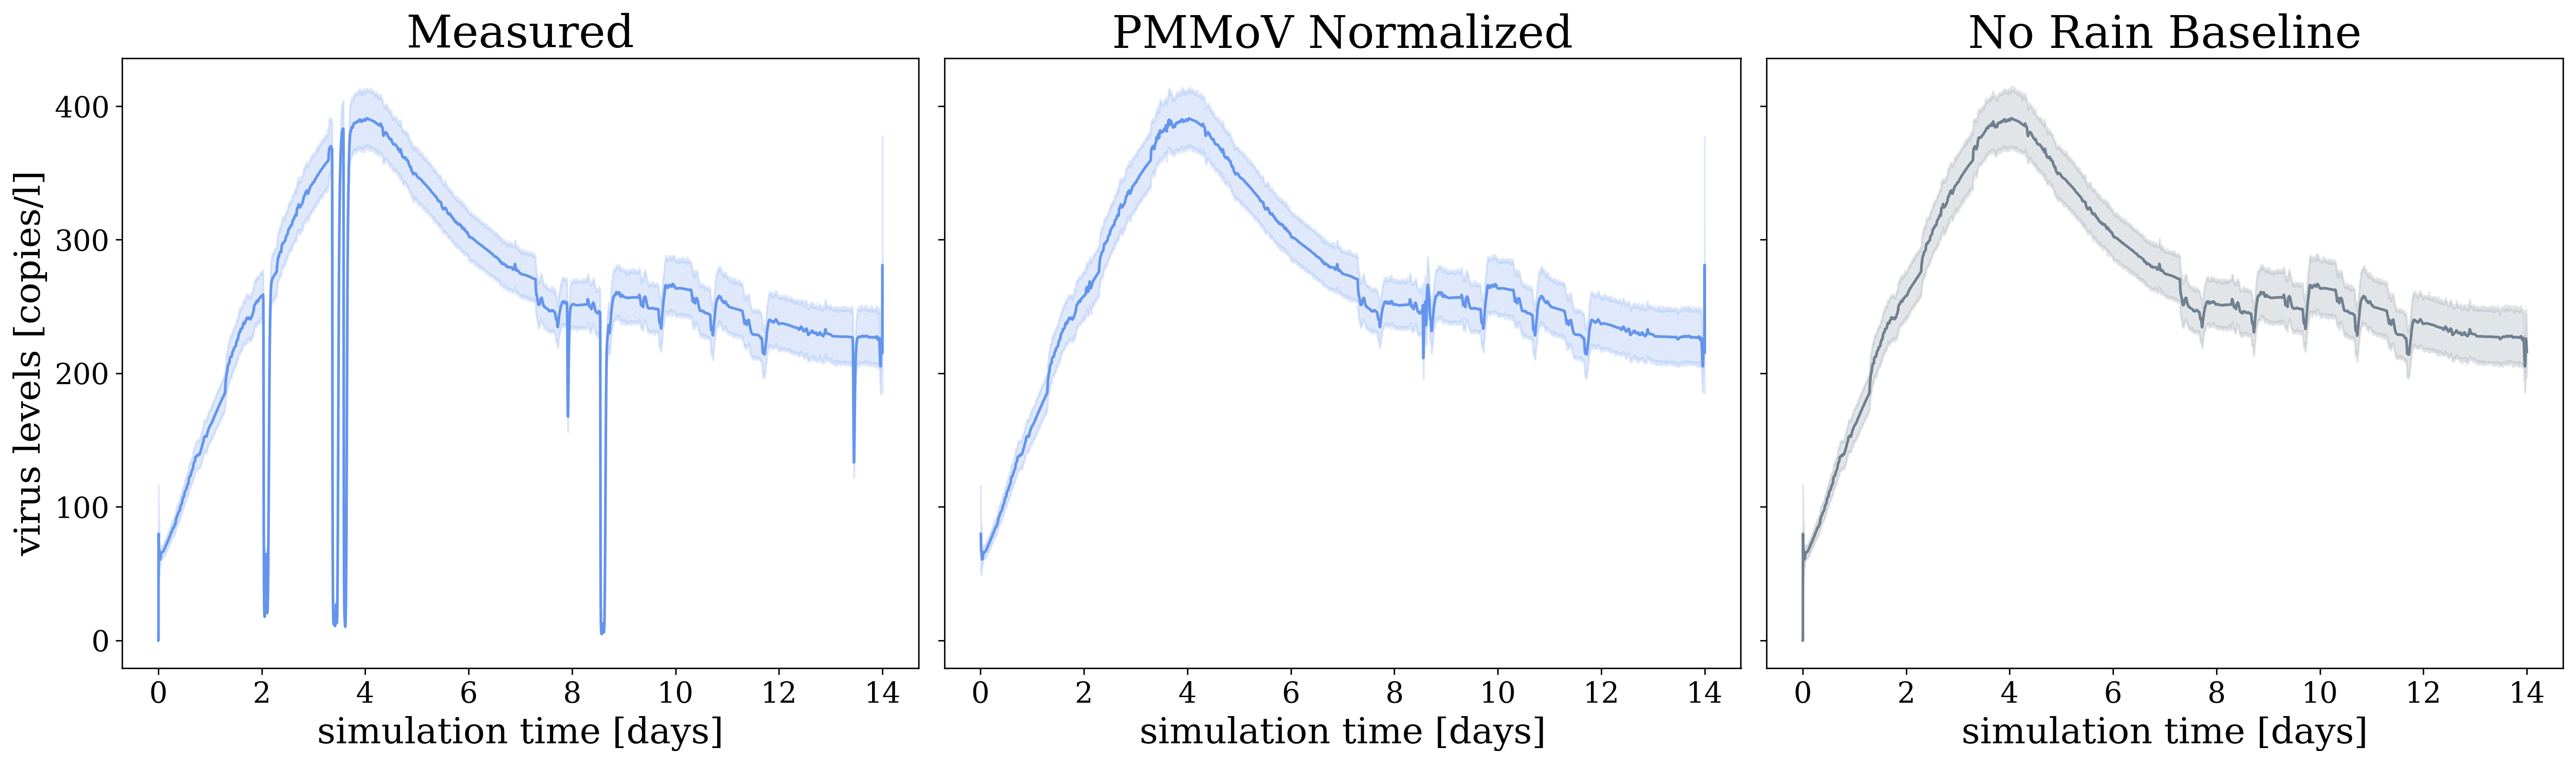

In [57]:
fig, axs = plt.subplots(ncols=3, sharey=True, sharex=True, figsize=(20, 6), dpi=300)

if rain_scenario == "Nieselregen":
    c_rain = "cornflowerblue"
else:
    c_rain = "navy"

sns.lineplot(df_Rain, x="time_in_days", y="COVID_copies/l", ax=axs[0], c=c_rain)
axs[0].set_title("Measured", fontsize=25)
axs[0].set_ylabel("virus levels [copies/l]", fontsize=20)
sns.lineplot(df_Rain, x="time_in_days", y="PMMoV_normalized_copies/l", ax=axs[1], c=c_rain)
axs[1].set_ylabel("normalized virus levels [copies/l]", fontsize=20)
axs[1].set_title("PMMoV Normalized", fontsize=25)    
sns.lineplot(df_KeinRegen, x="time_in_days", y="COVID_copies/l", ax=axs[2], c="slategrey")
axs[2].set_title("No Rain Baseline", fontsize=25)
axs[2].set_ylabel("virus levels [copies/l]", fontsize=20)

for i in range(3):
    axs[i].set_xlabel(f"simulation time [days]", fontsize=20) # , fontsize=15
    axs[i].tick_params(axis='x', labelsize=16)
    axs[i].tick_params(axis='y', labelsize=16)

fig.tight_layout()
fig.savefig(os.path.join(plot_path, f"overview_{resolution}_{rain_scenario}_{degradation_setting}_{sampling_point}.png"))

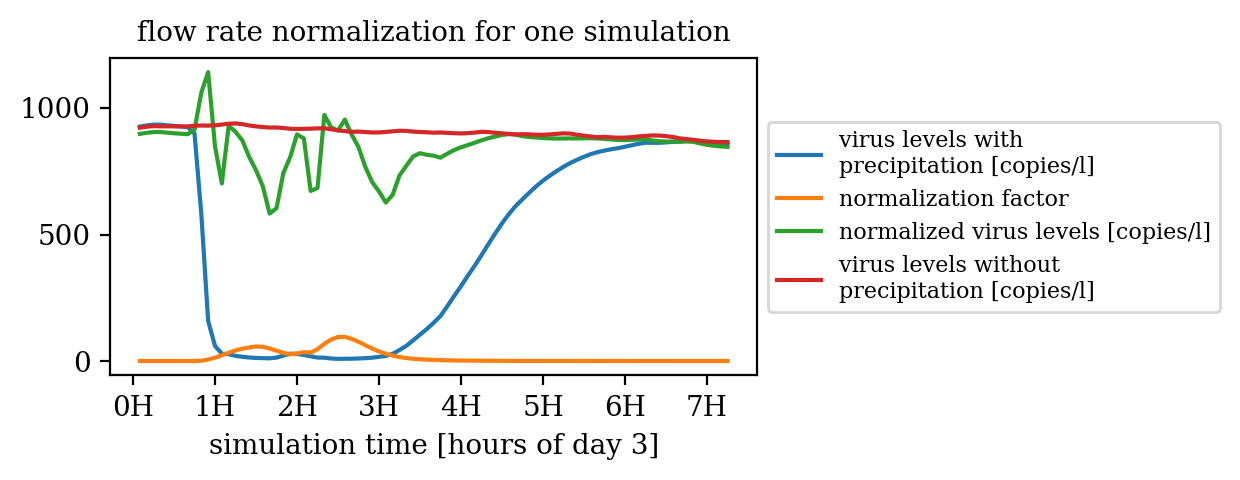

In [30]:
# old additional plot
"""
simulation_id = 2

df_Rain['minutes'] = (df_Rain['time'] - df_Rain['time'].min()).dt.total_seconds() // 60
df_KeinRegen['minutes'] = (df_KeinRegen['time'] - df_KeinRegen['time'].min()).dt.total_seconds() // 60

df_sub = df_Rain.loc[df_Rain.memilio_id==simulation_id, :]
df_sub_sub = df_sub.loc[(df_sub.minutes>= 2*24*60) & (df_sub.minutes<= 2.3*24*60), :]

fig, axs = plt.subplots(figsize=(6.3,2.5), dpi=200)
plt.plot(df_sub_sub["time"], df_sub_sub["copies/l"], label="virus levels with\nprecipitation [copies/l]")
plt.plot(df_sub_sub["time"], df_sub_sub["PMMoV_normalization_factor"], label="normalization factor")
plt.plot(df_sub_sub["time"], df_sub_sub["PMMoV_normalized_copies/l"], label="normalized virus levels [copies/l]")

df_sub = df_KeinRegen.loc[df_KeinRegen.memilio_id==simulation_id, :]
df_sub_sub = df_sub.loc[(df_sub.minutes>= 2*24*60) & (df_sub.minutes<= 2.3*24*60), :]
plt.plot(df_sub_sub["time"], df_sub_sub["copies/l"], label="virus levels without\nprecipitation [copies/l]")
date_form_2 = DateFormatter("%-HH")
axs.xaxis.set_major_formatter(date_form_2) 
axs.set_xlabel(f"simulation time [hours of day 3]", fontsize=10) # , fontsize=15
# axs.set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8)
plt.title("flow rate normalization for one simulation", fontsize=10)
plt.tight_layout()
fig.savefig(os.path.join(plot_path, f"examplary_{substance}_{rain_scenario}_{degradation_setting}_{sampling_point}_simulation_{simulation_id}.png"))
"""